<a href="https://colab.research.google.com/github/mmosoriov/proj5_DL/blob/ML_part2/Part1_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Miguel Mateo Osorio Vela, Matthew West

Development environment: Colab

# Part 1, ML: Baseline, PCA, Logistic Regression

- Task:
  - Come up with and implement a baseline for this task
    - Consider what technqiues we've covered in class might be relevant. Or come up with something all on your own.
    - Include a description of your baseline to accompany the implementation and explain why this baseline makes sense for this problem.
  - Compare the performance of your simple baseline with two of the following of your choice: PCA and Logistic Regression. Compare their performance on the Olivetti faces dataset on different evaluation scenarios
  - *If hyperparameters need to be selected, pull out a reasonable held-out set from the training set and performance hyperparameter selection.


- Evaluation scenarios:
  - Use 30% of the images for training and 70% for testing
  - Use 60% of the images for training and 40% for testing
  - Use 90% of the images for training and 10% for testing
  - Always use the first K images per person for training, and the remaining ones for testing (see data split code below)
  - Choose an evaluation method: CMC curve or confusion matrix. Run this for each combination of scenario and method.


- Discussion:
  - If you used a held-out set, how did you choose your method of held-out set selection method? If not, why was it not necessary?
    - What effect did your choice have on your final results?
  - Is there a clear difference in performance for different approaches?
  - Is there a clear difference in performance for different train/test data splits?

## Olivetti faces dataset (AT&T Laboratories Cambridge)

As described on the original website:

"*There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).*"

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

- Classes: 40
- Samples per class: 10
- Samples total: 400
- Dimensionality: 4096 (64x64 pixels)
- Pixel values: real, between 0 and 1


In [ ]:
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np

# Get the dataset

In [ ]:
faces = images = fetch_olivetti_faces()

_, img_height, img_width = images.images.shape

print(images.images.shape)

(400, 64, 64)


# Split the dataset

In [ ]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 5                            # use the first GALLERY_SIZE images per individual for training, the rest for testing

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices += indices[:GALLERY_SIZE]
  probe_indices += indices[GALLERY_SIZE:]

x_train = faces.images[gallery_indices].reshape(-1, img_height*img_width) # vectorize train images
y_train = faces.target[gallery_indices]
x_test = faces.images[probe_indices].reshape(-1, img_height*img_width)    # vectorize test images
y_test = faces.target[probe_indices]

print(x_train.shape, x_test.shape)

(200, 4096) (200, 4096)


# Visualize the splits

In [ ]:
def show_images(imgs, num_rows, num_cols):
  assert len(imgs) == num_rows*num_cols

  for i in range(num_rows):
    row = None
    for j in range(num_cols):
      if row is None:
        row = imgs[i*num_cols+j].reshape(img_height, img_width)*255.0
      else:
        row = np.concatenate((row, imgs[i*num_cols+j].reshape(img_height, img_width)*255.0), axis=1)
    cv2_imshow(row)

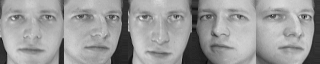

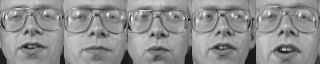

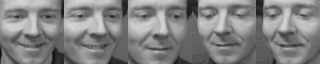

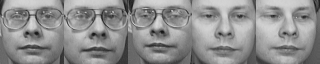

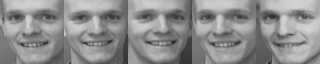

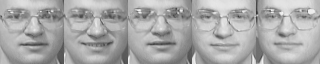

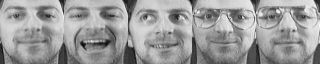

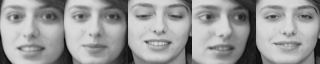

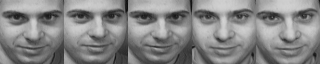

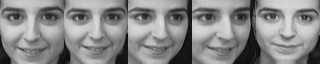

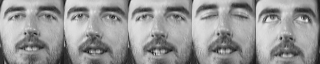

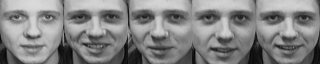

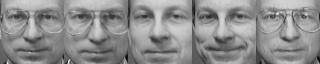

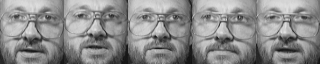

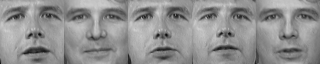

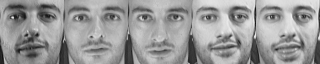

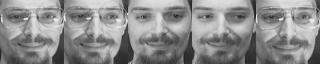

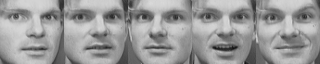

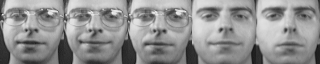

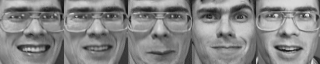

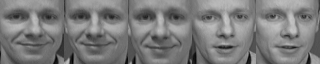

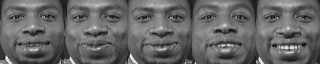

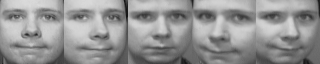

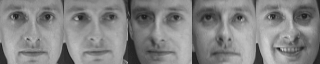

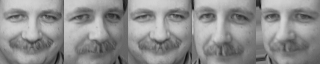

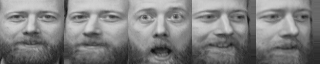

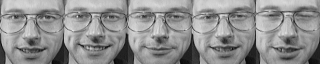

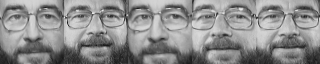

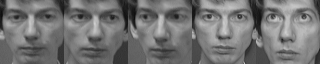

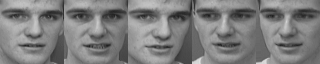

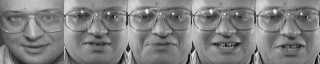

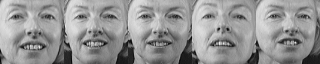

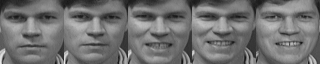

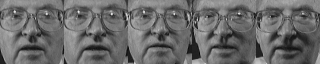

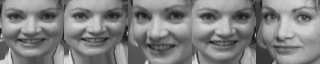

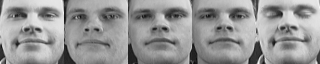

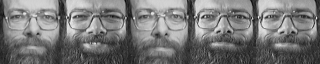

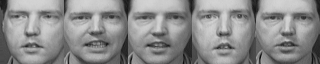

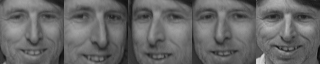

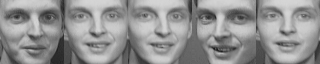

In [ ]:
show_images(x_train, N_IDENTITIES, GALLERY_SIZE)

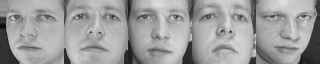

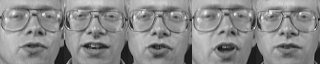

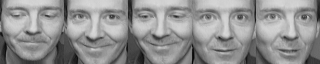

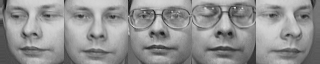

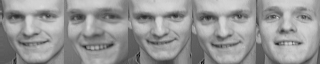

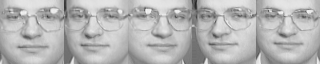

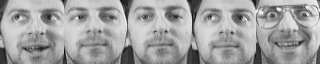

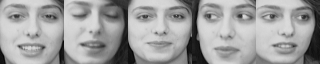

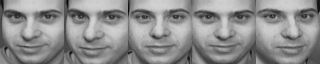

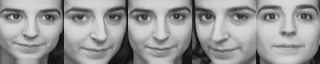

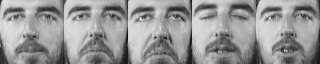

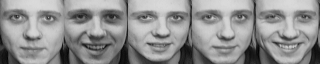

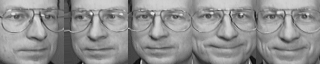

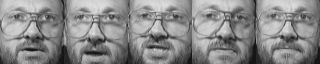

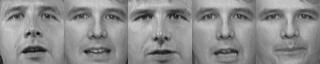

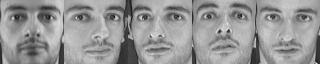

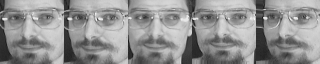

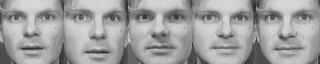

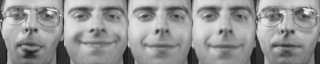

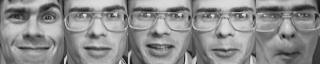

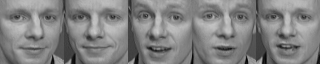

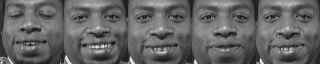

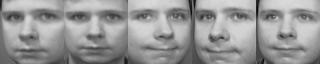

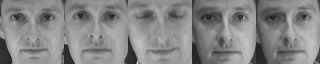

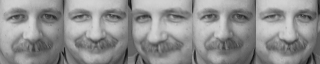

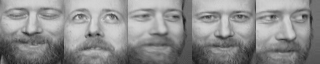

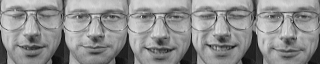

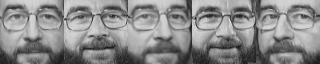

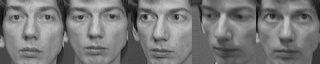

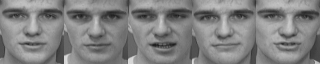

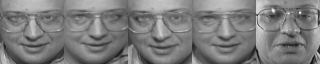

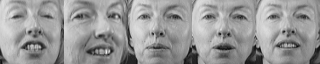

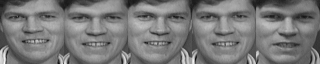

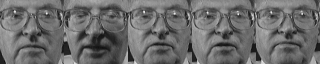

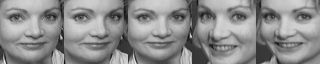

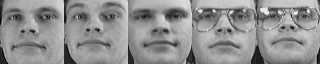

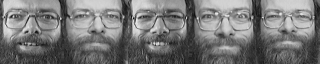

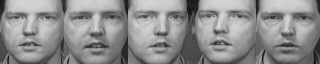

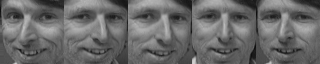

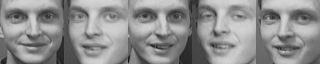

In [ ]:
show_images(x_test, N_IDENTITIES, 10 - GALLERY_SIZE)

# Implement your baseline

For our baseline we chose to implement a Naive Bayes Model. We chose this because we wanted to classify the images into the labels of people based on their features. It should also provide us with a decent starting point to compare against the other models. It is reasonable to assume that the Naive Bayes models should perform worse than all the other ones since it assumes the pixels are all independent of each other, something that is unlikely to be true for faces.

The Naive Bayes model works by assuming all features are independent of each other and then determining the probabilities of features given the label. Then the model can determine what label is most likely given the features present in the test example. The features of each image are either a 1 or a 0 for each pixel depending on if the intensity is over the threshold or not.

The threshold and the smoothing rate are both found using a held-out set.

In [ ]:
"""
DATA setup
"""
# Baseline
from sklearn.preprocessing import Binarizer # maps continous values -> 0 or 1
from sklearn.naive_bayes import BernoulliNB # Bernoulli(0 or 1) classifier in baseline
from sklearn.metrics import accuracy_score # to calculate how many predictions were correct
# PCA
from sklearn.model_selection import train_test_split # used in PCA to create small held-out set to tune number eigenfaces
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbors classifier
# Logistic regression
from sklearn.linear_model import LogisticRegression


print("Preparing Olivetti Faces dataset....")
X_full = images.data  # By documentation: shape of (400, 4096) => 400 images, 64x64 pixels flattened
y_full = images.target # Shape of (400,) => Labels associated with each image 0-39 // THE ANSWERS


# Reshape to (40 people, 10 images, 4096 pixels) to organize data by person
X_by_person = X_full.reshape(40, 10, 4096) # this forms a 3d block, which allows us to later say X_by_personl[0, :3] to retrieve the first 3 images of person 0
# Reshape to match structure above
y_by_person = y_full.reshape(40, 10)

Preparing Olivetti Faces dataset....


In [ ]:
"""
MODEL DEFINITIONS

"""

"""
BASELINE: Naive Bayes(Bernoulli, 0 or 1)
Logic: Feature values for each pixel are black or white depending if the intensity is > or < than 0.5
This is a simple and efficient way to generate an acceptable baseline that ignores noise.
It has the downside that we loose some "texture" data by categorizing everything as black or white.
"""

def run_baseline_naive_bayes(X_train, y_train, X_test, y_test):
  # count images
  n_samples = len(X_train)

  # count people, should be 40
  n_classes = len(np.unique(y_train))

  best_t = 0.5
  best_a = 1

  if n_samples * 0.2 >= n_classes:
    X_tr_sub, X_held_out, y_tr_sub, y_held_out = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

    best_acc = -1
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for t in thresholds:
      # Create binarizer
      to_binary = Binarizer(threshold=t)
      X_train_bin = to_binary.transform(X_tr_sub)

      Naive_Bayes_model = BernoulliNB(alpha=1, binarize=None) # initializes model which assumes pixels are independent
      Naive_Bayes_model.fit(X_train_bin, y_tr_sub)

      # Test on held-out set
      y_pred = Naive_Bayes_model.predict(X_held_out)

      acc = accuracy_score(y_held_out, y_pred)
      # print("Acc: ", acc, " Threshold: ", t)

      if acc > best_acc:
          best_acc = acc
          best_t = t

      best_acc = -1
      alphas = [1e-3, 1e-2, 1e-1, 1.0, 10.0]
      for a in alphas:
        # Create binarizer
        to_binary = Binarizer(threshold=best_t)
        X_train_bin = to_binary.transform(X_tr_sub)

        Naive_Bayes_model = BernoulliNB(alpha=a, binarize=None) # initializes model which assumes pixels are independent
        Naive_Bayes_model.fit(X_train_bin, y_tr_sub)

        # Test on held-out set
        y_pred = Naive_Bayes_model.predict(X_held_out)

        acc = accuracy_score(y_held_out, y_pred)

        if acc > best_acc:
            best_acc = acc
            best_a = a


  # Turn grayscale into 0 or 1
  to_binary = Binarizer(threshold=best_t)
  X_train_bin = to_binary.transform(X_train)
  X_test_bin = to_binary.transform(X_test)

  Naive_Bayes_model = BernoulliNB(alpha=best_a, binarize=None) # initializes model which assumes pixels are independent

  # Training: counts how often each pixel for person X is black/white
  Naive_Bayes_model.fit(X_train_bin, y_train)

  # Test model
  y_pred = Naive_Bayes_model.predict(X_test_bin)

  # print(f"Threshold: {best_t} alpha: {best_a}")
  return y_test, y_pred

"""
PCA: Principal Component Analysis
Problem: images are high dimensional data, in this case (64x64 pixels)= 4096 features. Some of these pixels are redundant(like background).
Logic: Finds the "principal components" which are the directions with maximum variance (these are called Eigenfaces)
  - It uses the classifier of the 1 nearest neighbour
  - It tunes the hyperparameters in a held-out set
"""

def run_pca_eigenfaces(X_train, y_train, X_test, y_test):

    # count images
    n_samples = len(X_train)

    # count people, should be 40
    n_classes = len(np.unique(y_train))

    # Default best number of components
    best_n = min(n_samples, 50)

    """
    We check that: Held-out set size > n_classes
    - This assures we have at least one image of each person for hyperparameters (#components) tuning
    """
    # If 20% of our data is greater than 40(people), then we know we will have an image of each person in held-out set
    if n_samples * 0.2 >= n_classes:
        # Create a 20% held-out set, stratify by labels to make sure each person is included, more info at: https://scikit-learn.org/stable/modules/cross_validation.html#stratification
        X_tr_sub, X_held_out, y_tr_sub, y_held_out = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

        best_acc = -1
        component_options = [20,40,60, 80,100,120, 140]

        for n in component_options:
            if n > len(X_tr_sub): continue

            #create PCA model
            pca = PCA(n_components=n, random_state=42)
            # Fit the model with training set and apply the dimensionality reduction on it.
            X_tr_pca = pca.fit_transform(X_tr_sub)
            # Just apply dimensionality reduction on held-out set.
            X_PCA_held_out = pca.transform(X_held_out)

            # Create Classifier of 1 nearest neighbour, "find the closest structural match"
            knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
            # Train the classiffier on the dimensional reduced data
            knn.fit(X_tr_pca, y_tr_sub)
            # Evaluate accuracy in the held-out set
            acc = knn.score(X_PCA_held_out, y_held_out)

            if acc > best_acc:
                best_acc = acc
                best_n = n
    else:
        # if data is too small, we guess 40 components as we cannot have more components than images
        best_n = min(40, n_samples)

    # Fit on FULL training set with the chosen number of components
    final_pca = PCA(n_components=best_n, random_state=42)
    X_train_pca = final_pca.fit_transform(X_train)
    # Apply dimensionality reduction on test set
    X_test_pca = final_pca.transform(X_test)

    # Train Nearest neighbour classifier on training set
    final_knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    final_knn.fit(X_train_pca, y_train)

    # Predict labels on test set the model hasnt seen before
    y_pred = final_knn.predict(X_test_pca)

    return y_test, y_pred

"""
Logistic Regression

"""

def run_logistic_regression(X_train, y_train, X_test, y_test):
    """
    solver was set to 'saga' because:
    1) faster for large data sets(4096 features) https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression-solvers
    2) It provides a penalty for L1 Regularization which is desired in our case, as we are trying to eliminate useless features(background)

    'C' was set to a smaller value from 1(default) to 0.05 to strengthen regularization

    'max_iter' was tuned to 400 iterations so that the solver will converge for all k values in around 1 min runtime
    """

    logis_reg = LogisticRegression(max_iter=400, solver = 'saga', C= 0.05 ,random_state=42)
    logis_reg.fit(X_train, y_train)
    y_pred = logis_reg.predict(X_test)

    return y_test, y_pred

# Run the experiments


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

"""
400 images in total , 10 images per  person
We choose first k images per person for training, and the rest for testing

k=3 (30% Train), k=6 (60% Train), k=9 (90% Train)
"""
train_sizes = [3, 6, 9]

# Create dict to store results
results = {
    'train_k': [],
    'Baseline': [],
    'PCA': [],
    'Logistic Regression': []
}

print(f"{'Images/Person train':<20} | {'Baseline':<15} | {'PCA':<15} | {'Logistic Reg ':<15}")
print("-" * 70)

for k in train_sizes:
    # Construct the split manually to ensure exactly k images per person
    X_train_list, y_train_list = [], []
    X_test_list, y_test_list = [], []

    for p_id in range(40):
        # Taking first k for train, rest for test
        X_train_list.append(X_by_person[p_id, :k, :])
        y_train_list.append(y_by_person[p_id, :k])
        X_test_list.append(X_by_person[p_id, k:, :])
        y_test_list.append(y_by_person[p_id, k:])

    # Use vstack to concatenate into a matrix and preserving k balance
    X_train = np.vstack(X_train_list)
    y_train = np.concatenate(y_train_list)
    X_test = np.vstack(X_test_list)
    y_test = np.concatenate(y_test_list)

    # Run Models
    nb_test, nb_pred = run_baseline_naive_bayes(X_train, y_train, X_test, y_test)
    pca_test, pca_pred = run_pca_eigenfaces(X_train, y_train, X_test, y_test)
    lr_test, lr_pred = run_logistic_regression(X_train, y_train, X_test, y_test)

    acc_nb = accuracy_score(nb_test, nb_pred)
    acc_pca = accuracy_score(pca_test, pca_pred)
    acc_lr = accuracy_score(lr_test, lr_pred)

    # Store Results
    results['train_k'].append(k)
    results['Baseline'].append((nb_test, nb_pred))
    results['PCA'].append((pca_test, pca_pred))
    results['Logistic Regression'].append((lr_test, lr_pred))

    print(f"{k:<20} | {acc_nb:.4f}          | {acc_pca:.4f}          | {acc_lr:.4f}")

Images/Person train  | Baseline        | PCA             | Logistic Reg   
----------------------------------------------------------------------
3                    | 0.5857          | 0.7536          | 0.7607
6                    | 0.6500          | 0.8625          | 0.8938
9                    | 0.7000          | 0.8750          | 0.9250


# Report your results

### Hyperparameter Selection
To find our hyperparameters we used a held-out set. We chose the set using the `train_test_split` function from scikit-learn. We used it to take 20% of the test set and use that as the held-out set.

The final choices of hyperparameters grealy affected our results. For example, the Naive Bayes model's accuracy changed by 80% at most between threshold hyperparamter choices.

When finetuning PCA, we randomly choose multiples of 20 to apply dimensionality reduction on it and try them consecutively. The best n (number of components) was chosen to later be used in the test set.

When finetuning Logistic regression, we had to dive through the libraries to find the parameters that will help us converge fast while at the same time get an acceptable accuracy. Our choices are better explained here:

solver was set to 'saga' because:
    
    1) faster for large data sets(4096 features) https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression-solvers
    
    2) It provides a penalty for L1 Regularization which is desired in our case, as we are trying to eliminate useless features(background)

'C' was set to a smaller value from 1(default) to 0.05 to strengthen regularization

'max_iter' was tuned to 400 iterations so that the solver will converge for all k values in around 1 min runtime


### Model Differences
There is a clear performance difference between the Naive Bayes model, the PCA model, and the Logistic Regression model. Naive Bayes was by far the worst of the three. It was consistently over 10% less accurate than the other two models were. The difference between the PCA and Logistic Regression models was consistent, but far closer. Those two saw only around a 5% difference in accuracy at most.
  
There was also a clear difference in training and test data splits as well. The splits where more data was left for training did better. The jump from 30% to 60% made a large difference. The training splits made such a difference, that the Naive Bayes model with 90% training data will beat the other two at 30% training data. The CMC matrices also show that the classifications are more centered on the diagonal line for the models with a higher training data split.

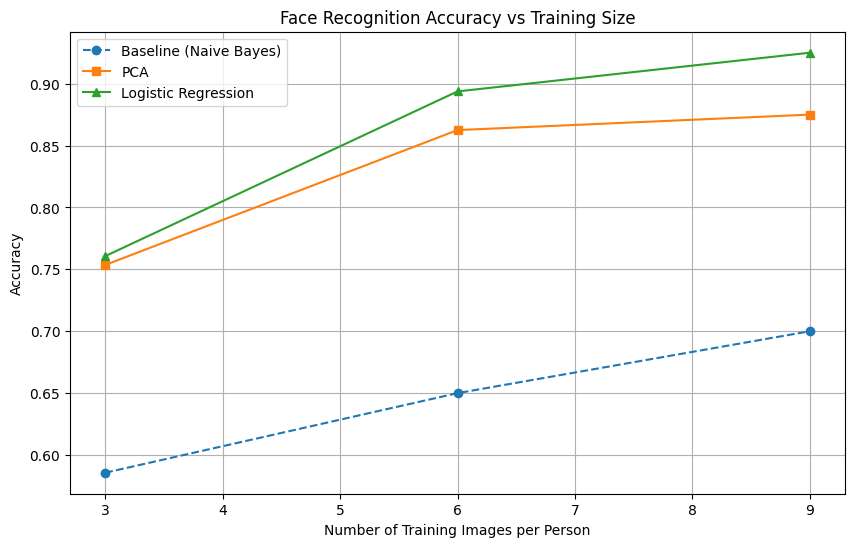

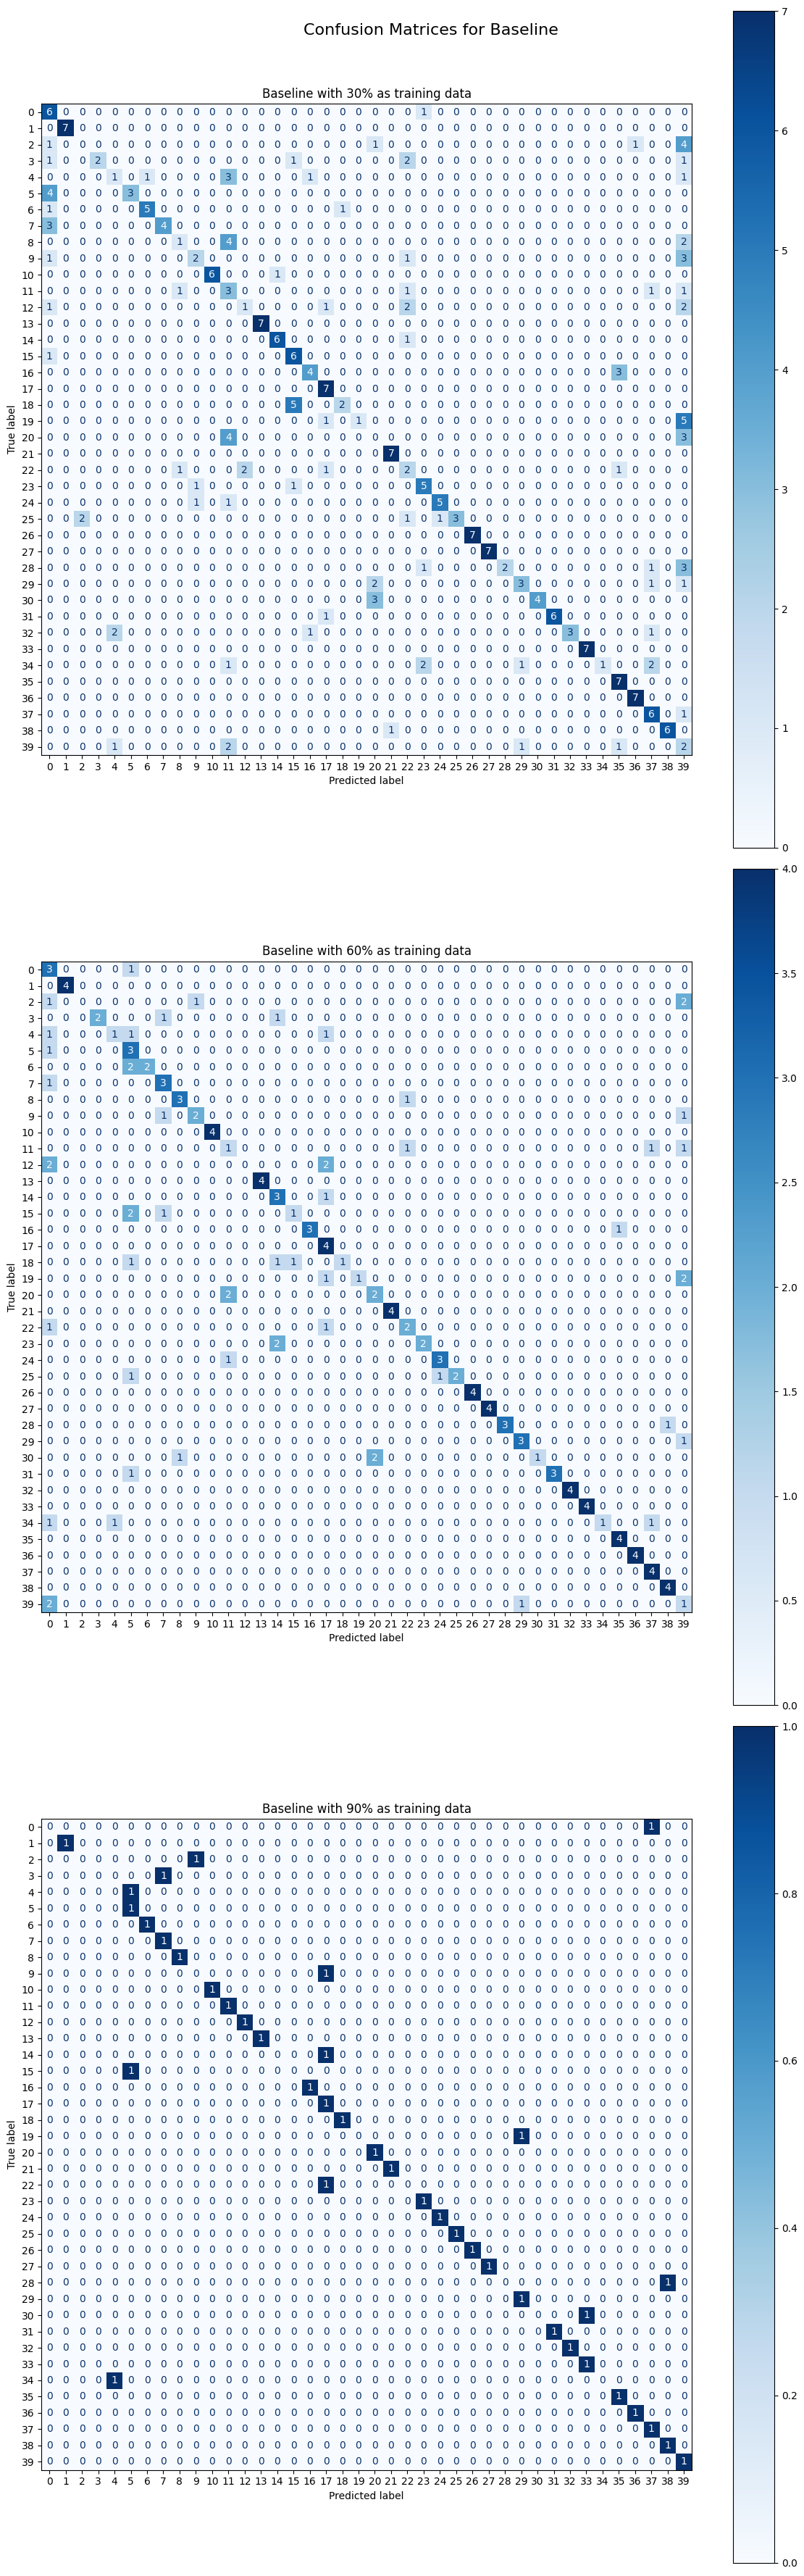

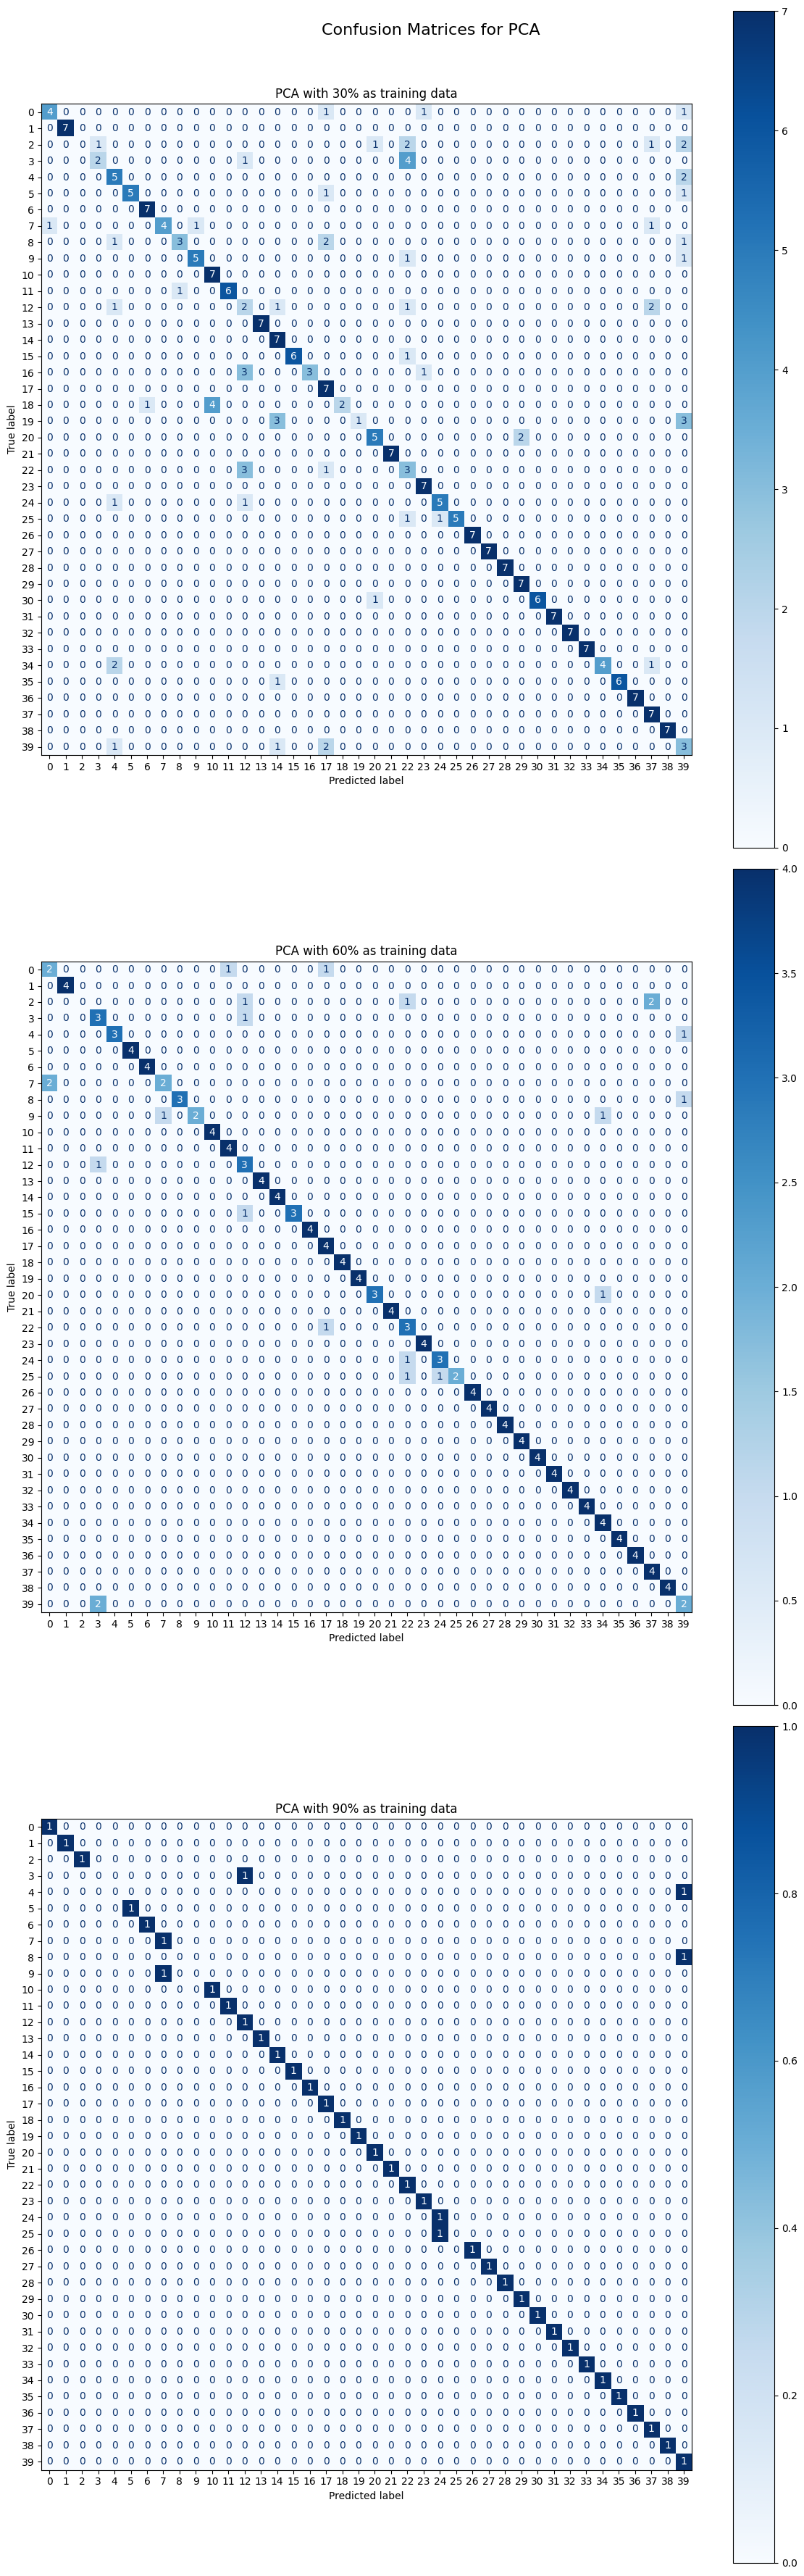

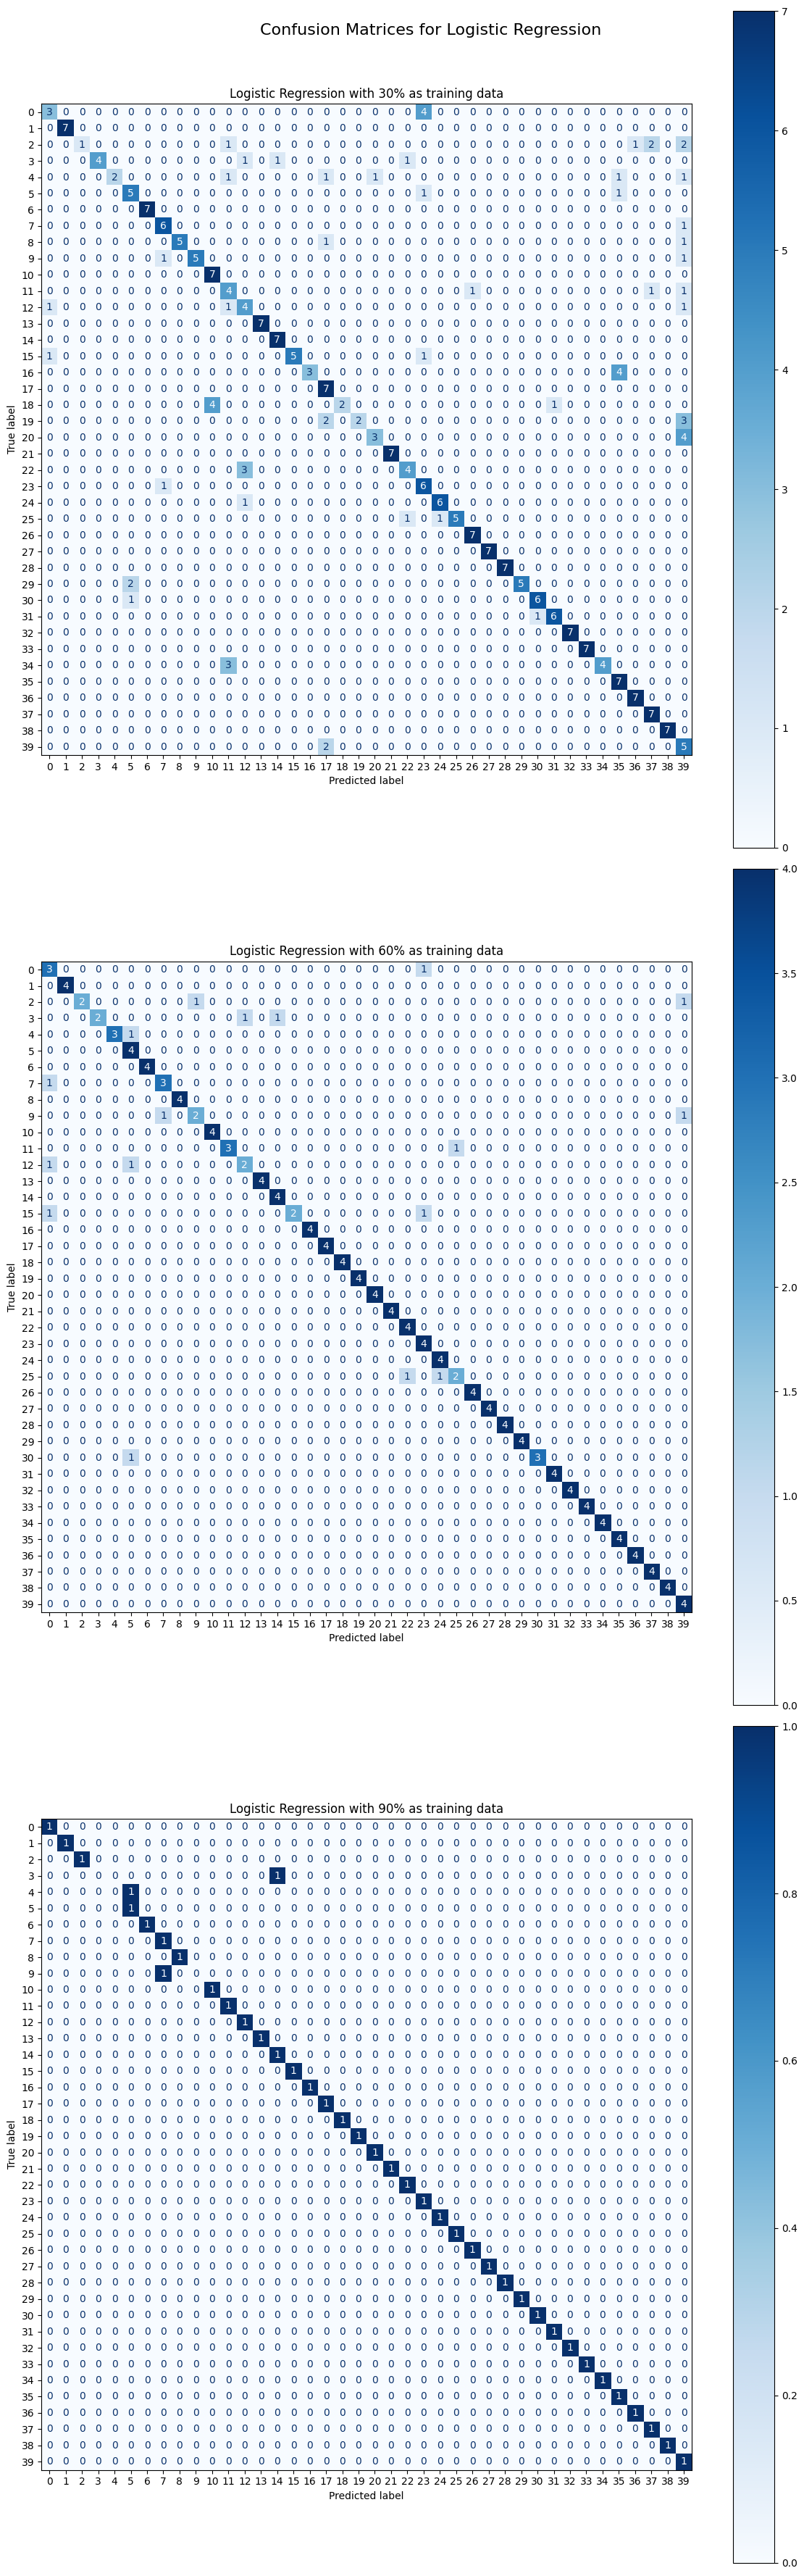

In [ ]:
import matplotlib.pyplot as plt # for plotting results

plt.figure(figsize=(10, 6))
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['Baseline']], marker='o', linestyle='--', label='Baseline (Naive Bayes)')
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['PCA']], marker='s', label='PCA')
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['Logistic Regression']], marker='^', label='Logistic Regression')

plt.title('Face Recognition Accuracy vs Training Size')
plt.xlabel('Number of Training Images per Person')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

labels = ['Baseline', 'PCA', 'Logistic Regression']
for label in labels:

  fig, axes = plt.subplots(len(train_sizes), 1, figsize=(12, 36))
  fig.suptitle(f"Confusion Matrices for {label}", fontsize=16)

  for ax, (test, pred), size in zip(axes, results[label], train_sizes):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test, pred))
    disp.plot(cmap='Blues', ax=ax, colorbar=True)
    ax.set_title(f"{label} with {size*10}% as training data")

  plt.tight_layout()
  plt.show()

# Part 2, DL: CNN and RNN

- **Tasks:**
  1. Compare the performance of a small CNN (LeNet-5) with the results you got from the last project using the Olivetti faces dataset (PCA and Logistic Regression)
  2. Choose, implement (if not available in a library), and run a baseline for the IMDB text classification from lecture
    - Consider what techniques would be appropriate for this task.
    - Also consider the fact that this is a text dataset, so some techniques might not work well or may be cumbersome to engineer.
    - Include a description of your baseline and explain why this baseline makes sense for this problem.
  3. Run a vanilla RNN on the IMDB text classification dataset and compare its performance against your baseline.

_Where it is relevant, make sure you follow deep learning best practices discussed in class. In particular, performing a hyperparameter search and setting up an proper train, dev, and test framework for evaluating hyperparameters and your final selected model._

- Evaluation scenarios:
  1. Facial Recognition
    - Use 20% of the images for training and 80% for testing
    - Use 50% of the images for training and 50% for testing
    - Use 80% of the images for training and 20% for testing
    - Always use the first K images per person for training, and the remaining ones for testing (see data split code below)
    - Plot CMC curve and confusion matrix for each combination of scenario

  2. Review Text Classification
    - Use 2,000 examples for training and 2,000 examples for testing (smaller than the example in lecture)
    - Experiment with several RNN configurations
    - Plot the training and validation plots for your RNN and for your baseline if your baseline has a training phase.
    - Plot a confusion matrix of the predictions.

- Discussion:
  1. Facial Recognition
    - Is LeNet-5 better than PCA/LDA/SVM?
    - Is there a clear difference in performance for different train/test data splits?
    - (extra credit) Does data augmentation improve the results?
  
  2. Review Text Classification
    - Is the vanilla RNN better than a simple baseline?
    - How sensitive is the RNN performance to hyperparameter selection?
    - (extra credit) Does data augmentation improve the results? More or less than for the facial recognition task? What properties of the two tasks do you think is leading to the data augmentation effects you are seeing?


# Run the facial recognition experiments

Here is the code for the CNN Model

In [ ]:
import tensorflow as tf
import math

def compile_LeNet(X_train, y_train, X_test, y_test, learning_rate, loss_func, batch_size):
  # Ensure weights are randomly initialized (to normal distribution)
  initializer = tf.keras.initializers.HeNormal()

  # Create LeNet-5 CNN model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', kernel_initializer=initializer, bias_initializer='zeros', input_shape=(64, 64, 1)))
  model.add(tf.keras.layers.MaxPool2D())
  model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu', kernel_initializer=initializer, bias_initializer='zeros'))
  model.add(tf.keras.layers.MaxPool2D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=120, activation='relu', kernel_initializer=initializer, bias_initializer='zeros',))
  model.add(tf.keras.layers.Dense(units=84, activation='relu', kernel_initializer=initializer, bias_initializer='zeros',))
  model.add(tf.keras.layers.Dense(units=40, activation = 'softmax', kernel_initializer=initializer, bias_initializer='zeros',))


  # count images
  n_samples = len(X_train)

  # count people, should be 40
  n_classes = len(np.unique(y_train))

  # Create Validation/Held-out Set for hyperparameter tuning
  x_val = None
  y_val = None
  print("Number of Samples", n_samples)
  print("Number of Classes", n_classes)
  if n_samples / n_classes > 2:
    X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
  else:
    X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train)

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss=loss_func, optimizer=optimizer,metrics=['accuracy'])

  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, verbose=1)
  model_save = tf.keras.callbacks.ModelCheckpoint(filepath="model.keras", monitor='val_accuracy', save_best_only=True)

  model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stop, model_save])

  model.load_weights('model.keras')
  if X_test is None:
    return model.predict(x_val), y_val
  else:
    return model.predict(X_test), y_test

# compile_LeNet(X_train, y_train, X_test, y_test, 0.01, 'sparse_categorical_crossentropy', 16)


In [ ]:
def run_LeNet(X_train, y_train, X_test, y_test):
  # Hyperparameters
  learning_rate = [0.001, 0.01, 0.1]
  loss_func = 'sparse_categorical_crossentropy'
  batch_size = [16, 32, 64]

  best_acc = -1
  best_hyper_params = None

  for learn in learning_rate:
    for size in batch_size:
      print(f"Learning rate {learn}  batch size {size}: ")
      predictions, labels = compile_LeNet(X_train, y_train, X_test=None, y_test=None, learning_rate=learn, loss_func=loss_func, batch_size=size)
      pred_classes = np.argmax(predictions, axis=1)
      accuracy = np.mean(pred_classes == labels)

      if accuracy > best_acc:
        best_acc = accuracy
        best_hyper_params = (learn, size)


  predictions, labels = compile_LeNet(X_train, y_train, X_test, y_test, learning_rate=best_hyper_params[0], loss_func=loss_func, batch_size=best_hyper_params[1])
  return predictions, labels



In [ ]:
def generateLeNetData(X_by_person, y_by_person):
  results = {
    'train_k': [],
    'CNN_raw' : [],
    'CNN': []
  }

  ksplits = [2, 5, 8]
  for k in ksplits:
    print(f"{k}0% is training data")
    X_train_list, y_train_list = [], []
    X_test_list, y_test_list = [], []

    for p_id in range(40):
      # Taking first k for train, rest for test
      X_train_list.append(X_by_person[p_id, :k, :])
      y_train_list.append(y_by_person[p_id, :k])
      X_test_list.append(X_by_person[p_id, k:, :])
      y_test_list.append(y_by_person[p_id, k:])

    # Use vstack to concatenate into a matrix and preserving k balance
    X_train = np.vstack(X_train_list)
    X_train = X_train.reshape(-1, 64, 64)
    y_train = np.concatenate(y_train_list)

    X_test = np.vstack(X_test_list)
    X_test = X_test.reshape(-1, 64, 64)
    y_test = np.concatenate(y_test_list)

    results['train_k'].append(k)
    predictions, labels = run_LeNet(X_train, y_train, X_test, y_test)
    results['CNN_raw'].append((predictions, labels))
    results['CNN'].append((np.argmax(predictions, axis=1), labels))
  return results

cnn_results = generateLeNetData(X_by_person, y_by_person)

20% is training data
Learning rate 0.001  batch size 16: 
Number of Samples 80
Number of Classes 40
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.0000e+00 - loss: 3.9948 - val_accuracy: 0.0500 - val_loss: 3.7478
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.0719 - loss: 3.7247 - val_accuracy: 0.0250 - val_loss: 3.7036
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.0359 - loss: 3.6565 - val_accuracy: 0.0250 - val_loss: 3.6865
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0406 - loss: 3.6416 - val_accuracy: 0.0250 - val_loss: 3.6628
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.0719 - loss: 3.5995 - val_accuracy: 0.0750 - val_loss: 3.6298
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.0562 - loss: 3.5631 - val_accuracy: 0.0750 - val_loss: 3.5852
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1688 - loss: 3.4857 - val_accuracy: 0.1250 - val_loss: 3.5474
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2625 - loss: 3.4499 - val_accuracy: 0.1500 - val_loss: 3.5097
Epoch 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.0000e+00 - loss: 4.6821 - val_accuracy: 0.0500 - val_loss: 4.5961
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0542 - loss: 4.6052 - val_accuracy: 0.0250 - val_loss: 3.9665
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0271 - loss: 3.9426 - val_accuracy: 0.0250 - val_loss: 3.7995
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0271 - loss: 3.7995 - val_accuracy: 0.0250 - val_loss: 3.7491
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.0271 - loss: 3.7506 - val_accuracy: 0.0250 - val_loss: 3.7132
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0542 - loss: 3.6874 - val_accuracy: 0.0250 - val_loss: 3.7064
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0271 - loss: 3.6825 - val_accuracy: 0.0250 - val_loss: 3.6983
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0271 - loss: 3.6839 - val_accuracy: 0.0250 - val_loss: 3.7156
Epoch 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0500 - loss: 3.7778 - val_accuracy: 0.0250 - val_loss: 3.7603
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.0250 - loss: 3.7332 - val_accuracy: 0.0750 - val_loss: 3.7093
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.0750 - loss: 3.6797 - val_accuracy: 0.0500 - val_loss: 3.6714
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.0500 - loss: 3.6231 - val_accuracy: 0.0250 - val_loss: 3.6540
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.1000 - loss: 3.5892 - val_accuracy: 0.0500 - val_loss: 3.6295
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.1250 - loss: 3.5504 - val_accuracy: 0.0750 - val_loss: 3.5966
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.2250 - loss: 3.5032 - val_accuracy: 0.1250 - val_loss: 3.5632
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2250 - loss: 3.4431 - val_accuracy: 0.1000 - val_loss: 3.5352
Epoch 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.0000e+00 - loss: 5.1718 - val_accuracy: 0.0250 - val_loss: 3.7097
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.0203 - loss: 3.6826 - val_accuracy: 0.0250 - val_loss: 3.6886
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.0203 - loss: 3.6913 - val_accuracy: 0.0250 - val_loss: 3.6891
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.0000e+00 - loss: 3.6933 - val_accuracy: 0.0250 - val_loss: 3.6890
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0125 - loss: 3.6921 - val_accuracy: 0.0250 - val_loss: 3.6797
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1437 - loss: 3.6749 - val_accuracy: 0.0500 - val_loss: 3.6739
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0328 - loss: 3.6753 - val_accuracy: 0.0250 - val_loss: 3.6861
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.0484 - loss: 3.6856 - val_accuracy: 0.0250 - val_loss: 3.6876
Ep

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.0000e+00 - loss: 5.5014 - val_accuracy: 0.0250 - val_loss: 6.3975
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.0271 - loss: 6.2053 - val_accuracy: 0.0500 - val_loss: 3.6877
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.0604 - loss: 3.6760 - val_accuracy: 0.0250 - val_loss: 3.7108
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.0271 - loss: 3.6829 - val_accuracy: 0.0250 - val_loss: 3.7133
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0437 - loss: 3.6902 - val_accuracy: 0.0500 - val_loss: 3.6779
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.0708 - loss: 3.6562 - val_accuracy: 0.0500 - val_loss: 3.6845
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.0542 - loss: 3.6774 - val_accuracy: 0.0250 - val_loss: 3.6881
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.0271 - loss: 3.6877 - val_accuracy: 0.0250 - val_loss: 3.6898
Epoc

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0250 - loss: 4.3426 - val_accuracy: 0.0250 - val_loss: 7.9673
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.0250 - loss: 7.8042 - val_accuracy: 0.0250 - val_loss: 4.0627
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.0250 - loss: 4.0527 - val_accuracy: 0.0000e+00 - val_loss: 3.6885
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.0250 - loss: 3.6850 - val_accuracy: 0.0250 - val_loss: 3.6894
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.0250 - loss: 3.6892 - val_accuracy: 0.0250 - val_loss: 3.6895
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.0250 - loss: 3.6895 - val_accuracy: 0.0250 - val_loss: 3.6897
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.0250 - loss: 3.6897 - val_accuracy: 0.0250 - val_loss: 3.6898
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.0250 - loss: 3.6898 - val_accuracy: 0.0250 - val_loss: 3.6899
Ep

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.0000e+00 - loss: 100.2962 - val_accuracy: 0.0250 - val_loss: 3.7854
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0000e+00 - loss: 3.9339 - val_accuracy: 0.0250 - val_loss: 3.7481
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0000e+00 - loss: 3.8719 - val_accuracy: 0.0250 - val_loss: 3.7191
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0359 - loss: 3.7471 - val_accuracy: 0.0250 - val_loss: 3.7121
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.0125 - loss: 3.7183 - val_accuracy: 0.0250 - val_loss: 3.7114
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0359 - loss: 3.6876 - val_accuracy: 0.0250 - val_loss: 3.7100
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0203 - loss: 3.7213 - val_accuracy: 0.0250 - val_loss: 3.7063
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0000e+00 - loss: 3.7128 - val_accuracy: 0.0250 - val_loss:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.0000e+00 - loss: 234.3636 - val_accuracy: 0.0250 - val_loss: 21.5831
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0271 - loss: 17.5629 - val_accuracy: 0.0250 - val_loss: 3.7076
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0271 - loss: 3.7189 - val_accuracy: 0.0250 - val_loss: 3.7141
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.0271 - loss: 3.7286 - val_accuracy: 0.0250 - val_loss: 3.7162
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.0271 - loss: 3.7285 - val_accuracy: 0.0250 - val_loss: 3.7173
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.0271 - loss: 3.7118 - val_accuracy: 0.0250 - val_loss: 3.7162
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.0271 - loss: 3.7015 - val_accuracy: 0.0250 - val_loss: 3.7078
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.0271 - loss: 3.7085 - val_accuracy: 0.0250 - val_loss: 3.708

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0250 - loss: 4.0817 - val_accuracy: 0.0250 - val_loss: 595.7231
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.0250 - loss: 594.7358 - val_accuracy: 0.0250 - val_loss: 4.6778
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.0250 - loss: 4.5436 - val_accuracy: 0.0250 - val_loss: 3.7129
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.0250 - loss: 3.7238 - val_accuracy: 0.0250 - val_loss: 3.7459
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.0250 - loss: 3.7459 - val_accuracy: 0.0250 - val_loss: 3.7394
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.0250 - loss: 3.7394 - val_accuracy: 0.0250 - val_loss: 3.7055
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.0250 - loss: 3.7055 - val_accuracy: 0.0250 - val_loss: 3.7005
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.0250 - loss: 3.7005 - val_accuracy: 0.0250 - val_loss: 3.6956
Ep

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0250 - loss: 4.7187 - val_accuracy: 0.0250 - val_loss: 4.4414
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.0250 - loss: 4.4841 - val_accuracy: 0.0250 - val_loss: 3.9518
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.0500 - loss: 3.9719 - val_accuracy: 0.0000e+00 - val_loss: 3.9195
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.0250 - loss: 3.9054 - val_accuracy: 0.0000e+00 - val_loss: 3.9120
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.0000e+00 - loss: 3.8862 - val_accuracy: 0.0000e+00 - val_loss: 3.8940
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.0250 - loss: 3.8632 - val_accuracy: 0.0250 - val_loss: 3.8502
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.0250 - loss: 3.8072 - val_accuracy: 0.0250 - val_loss: 3.7923
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.0250 - loss: 3.7446 - val_accuracy: 0.0250 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.0202 - loss: 4.4118 - val_accuracy: 0.0500 - val_loss: 3.6926
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0121 - loss: 3.7185 - val_accuracy: 0.0500 - val_loss: 3.6517
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0499 - loss: 3.6442 - val_accuracy: 0.0500 - val_loss: 3.6073
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.1548 - loss: 3.5626 - val_accuracy: 0.2000 - val_loss: 3.4996
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.2723 - loss: 3.4079 - val_accuracy: 0.1000 - val_loss: 3.3600
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1914 - loss: 3.2743 - val_accuracy: 0.2250 - val_loss: 3.1423
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3684 - loss: 2.9041 - val_accuracy: 0.2500 - val_loss: 2.8309
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4608 - loss: 2.4807 - val_accuracy: 0.3750 - val_loss: 2.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.0181 - loss: 3.8173 - val_accuracy: 0.0500 - val_loss: 3.6807
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.0377 - loss: 3.7007 - val_accuracy: 0.0250 - val_loss: 3.6397
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.0563 - loss: 3.6246 - val_accuracy: 0.0750 - val_loss: 3.5836
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.0701 - loss: 3.5575 - val_accuracy: 0.1000 - val_loss: 3.5029
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.1447 - loss: 3.4346 - val_accuracy: 0.2500 - val_loss: 3.3865
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3270 - loss: 3.2704 - val_accuracy: 0.3750 - val_loss: 3.2272
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.3839 - loss: 3.0785 - val_accuracy: 0.3000 - val_loss: 3.0525
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.3859 - loss: 2.8533 - val_accuracy: 0.4500 - val_loss: 2.8110
Epoch 9/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.0090 - loss: 3.7152 - val_accuracy: 0.0250 - val_loss: 3.6536
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.0582 - loss: 3.6335 - val_accuracy: 0.1500 - val_loss: 3.5911
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2176 - loss: 3.5245 - val_accuracy: 0.1750 - val_loss: 3.5023
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2270 - loss: 3.3762 - val_accuracy: 0.1750 - val_loss: 3.3687
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2820 - loss: 3.1909 - val_accuracy: 0.3500 - val_loss: 3.1911
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4086 - loss: 2.9128 - val_accuracy: 0.3000 - val_loss: 3.0054
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4914 - loss: 2.6427 - val_accuracy: 0.3500 - val_loss: 2.7456
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5508 - loss: 2.3153 - val_accuracy: 0.4750 - val_loss: 2.5035
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.0135 - loss: 5.3177 - val_accuracy: 0.0250 - val_loss: 3.6893
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0018 - loss: 3.6939 - val_accuracy: 0.0000e+00 - val_loss: 3.6855
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0173 - loss: 3.6897 - val_accuracy: 0.0250 - val_loss: 3.6850
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0377 - loss: 3.6566 - val_accuracy: 0.0250 - val_loss: 3.6895
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0107 - loss: 3.6956 - val_accuracy: 0.0250 - val_loss: 3.6903
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.0154 - loss: 3.6890 - val_accuracy: 0.0250 - val_loss: 3.6898
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0303 - loss: 3.6938 - val_accuracy: 0.0250 - val_loss: 3.6896
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0341 - loss: 3.6877 - val_accuracy: 0.0250 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.0537 - loss: 7.6989 - val_accuracy: 0.0250 - val_loss: 3.6844
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0128 - loss: 3.6891 - val_accuracy: 0.0250 - val_loss: 3.6873
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.0136 - loss: 3.6855 - val_accuracy: 0.0750 - val_loss: 3.6734
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.0447 - loss: 3.6757 - val_accuracy: 0.0250 - val_loss: 3.6563
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.0317 - loss: 3.6415 - val_accuracy: 0.1000 - val_loss: 3.5866
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1281 - loss: 3.5474 - val_accuracy: 0.0750 - val_loss: 3.4263
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.1941 - loss: 3.2335 - val_accuracy: 0.1500 - val_loss: 3.0647
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.3274 - loss: 2.6287 - val_accuracy: 0.2500 - val_loss: 2.8409
Epoch 9

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.0141 - loss: 3.8763 - val_accuracy: 0.0250 - val_loss: 3.6881
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.0223 - loss: 3.6901 - val_accuracy: 0.0250 - val_loss: 3.6892
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.0223 - loss: 3.6885 - val_accuracy: 0.0250 - val_loss: 3.6897
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.0383 - loss: 3.6905 - val_accuracy: 0.0250 - val_loss: 3.6894
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.0461 - loss: 3.6879 - val_accuracy: 0.0250 - val_loss: 3.6876
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.0312 - loss: 3.6840 - val_accuracy: 0.0500 - val_loss: 3.6486
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.0727 - loss: 3.6238 - val_accuracy: 0.0250 - val_loss: 3.4731
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.0902 - loss: 3.4505 - val_accuracy: 0.1250 - val_loss: 3.1585
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.0054 - loss: 7.9302 - val_accuracy: 0.0250 - val_loss: 3.7084
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.0439 - loss: 3.7265 - val_accuracy: 0.0250 - val_loss: 3.7077
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0000e+00 - loss: 3.7222 - val_accuracy: 0.0250 - val_loss: 3.6988
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0245 - loss: 3.7130 - val_accuracy: 0.0250 - val_loss: 3.6940
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0341 - loss: 3.6967 - val_accuracy: 0.0250 - val_loss: 3.6926
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0086 - loss: 3.7130 - val_accuracy: 0.0250 - val_loss: 3.6906
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0115 - loss: 3.6996 - val_accuracy: 0.0250 - val_loss: 3.6907
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0346 - loss: 3.6942 - val_accuracy: 0.0250 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.0000e+00 - loss: 1648.2234 - val_accuracy: 0.0250 - val_loss: 4.2226
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0369 - loss: 4.2901 - val_accuracy: 0.0250 - val_loss: 3.7159
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0227 - loss: 3.7301 - val_accuracy: 0.0250 - val_loss: 3.7110
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0085 - loss: 3.7057 - val_accuracy: 0.0250 - val_loss: 3.7113
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0129 - loss: 3.7001 - val_accuracy: 0.0250 - val_loss: 3.7080
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0077 - loss: 3.7163 - val_accuracy: 0.0250 - val_loss: 3.7031
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0072 - loss: 3.7177 - val_accuracy: 0.0250 - val_loss: 3.6995
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0258 - loss: 3.6973 - val_accuracy: 0.0250 - val_loss: 3.6975
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.0180 - loss: 1722.1389 - val_accuracy: 0.0250 - val_loss: 130.4952
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.0230 - loss: 88.8920 - val_accuracy: 0.0250 - val_loss: 3.8768
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.0461 - loss: 3.9117 - val_accuracy: 0.0250 - val_loss: 3.7553
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.0184 - loss: 3.7686 - val_accuracy: 0.0250 - val_loss: 3.7545
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0152 - loss: 3.7603 - val_accuracy: 0.0250 - val_loss: 3.7501
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.0051 - loss: 3.7435 - val_accuracy: 0.0250 - val_loss: 3.7221
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.0359 - loss: 3.7233 - val_accuracy: 0.0250 - val_loss: 3.7207
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.0281 - loss: 3.7072 - val_accuracy: 0.0250 - val_loss: 3.71

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.0123 - loss: 4.3490 - val_accuracy: 0.0250 - val_loss: 3.7268
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0236 - loss: 3.7344 - val_accuracy: 0.0500 - val_loss: 3.6681
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.0630 - loss: 3.6469 - val_accuracy: 0.0250 - val_loss: 3.6422
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.0544 - loss: 3.5938 - val_accuracy: 0.1250 - val_loss: 3.6065
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0691 - loss: 3.5426 - val_accuracy: 0.0750 - val_loss: 3.5085
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1502 - loss: 3.3798 - val_accuracy: 0.1500 - val_loss: 3.4032
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2017 - loss: 3.2267 - val_accuracy: 0.1750 - val_loss: 3.2446
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2247 - loss: 3.0386 - val_accuracy: 0.2500 - val_loss: 2.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.0267 - loss: 3.7212 - val_accuracy: 0.0312 - val_loss: 3.6506
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0531 - loss: 3.6028 - val_accuracy: 0.0625 - val_loss: 3.5323
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1576 - loss: 3.4246 - val_accuracy: 0.1719 - val_loss: 3.2014
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3420 - loss: 2.9806 - val_accuracy: 0.4219 - val_loss: 2.5522
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4924 - loss: 2.2356 - val_accuracy: 0.5469 - val_loss: 1.9118
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7331 - loss: 1.3152 - val_accuracy: 0.6875 - val_loss: 1.2536
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8382 - loss: 0.7728 - val_accuracy: 0.7500 - val_loss: 1.0567
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9416 - loss: 0.4391 - val_accuracy: 0.8125 - val_loss: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.0348 - loss: 3.8480 - val_accuracy: 0.0781 - val_loss: 3.6889
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.0431 - loss: 3.6675 - val_accuracy: 0.1250 - val_loss: 3.6480
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.0704 - loss: 3.5980 - val_accuracy: 0.1250 - val_loss: 3.5296
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2001 - loss: 3.4420 - val_accuracy: 0.1250 - val_loss: 3.3430
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.2046 - loss: 3.1759 - val_accuracy: 0.2500 - val_loss: 3.0602
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3570 - loss: 2.8509 - val_accuracy: 0.1719 - val_loss: 3.0011
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.3894 - loss: 2.5371 - val_accuracy: 0.3906 - val_loss: 2.4254
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5898 - loss: 1.9721 - val_accuracy: 0.4688 - val_loss: 2.0692
Epoch 9/50

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.0396 - loss: 3.7481 - val_accuracy: 0.0156 - val_loss: 3.6889
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.0562 - loss: 3.6385 - val_accuracy: 0.0781 - val_loss: 3.6308
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.0964 - loss: 3.5880 - val_accuracy: 0.1094 - val_loss: 3.5754
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.2141 - loss: 3.4856 - val_accuracy: 0.1406 - val_loss: 3.4918
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.2714 - loss: 3.3358 - val_accuracy: 0.2344 - val_loss: 3.3594
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.3568 - loss: 3.1430 - val_accuracy: 0.2656 - val_loss: 3.1558
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.3318 - loss: 2.8908 - val_accuracy: 0.2969 - val_loss: 2.9255
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.4938 - loss: 2.6101 - val_accuracy: 0.3750 - val_loss: 2.6655
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.0069 - loss: 5.7378 - val_accuracy: 0.0156 - val_loss: 3.6937
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0461 - loss: 3.6913 - val_accuracy: 0.0156 - val_loss: 3.6929
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0351 - loss: 3.6892 - val_accuracy: 0.0156 - val_loss: 3.6956
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0188 - loss: 3.6901 - val_accuracy: 0.0156 - val_loss: 3.6980
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0447 - loss: 3.6905 - val_accuracy: 0.0156 - val_loss: 3.6971
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0282 - loss: 3.6888 - val_accuracy: 0.0156 - val_loss: 3.6987
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0225 - loss: 3.6918 - val_accuracy: 0.0156 - val_loss: 3.7004
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0088 - loss: 3.6877 - val_accuracy: 0.0156 - val_loss: 3.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.0171 - loss: 3.8026 - val_accuracy: 0.0156 - val_loss: 3.6911
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.0403 - loss: 3.6845 - val_accuracy: 0.0781 - val_loss: 3.5963
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.0291 - loss: 3.8332 - val_accuracy: 0.0000e+00 - val_loss: 3.6511
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.0391 - loss: 3.5613 - val_accuracy: 0.1094 - val_loss: 3.5010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.2016 - loss: 3.2300 - val_accuracy: 0.2344 - val_loss: 3.3692
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.2611 - loss: 2.8259 - val_accuracy: 0.3125 - val_loss: 2.8510
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.3908 - loss: 2.1983 - val_accuracy: 0.4375 - val_loss: 2.4725
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6024 - loss: 1.4784 - val_accuracy: 0.5312 - val_loss: 2.4922
Epoch 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.0229 - loss: 4.1987 - val_accuracy: 0.0156 - val_loss: 3.6899
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.0286 - loss: 3.6886 - val_accuracy: 0.0156 - val_loss: 3.6974
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.0297 - loss: 3.6878 - val_accuracy: 0.0156 - val_loss: 3.7026
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.0281 - loss: 3.6924 - val_accuracy: 0.0156 - val_loss: 3.7059
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.0188 - loss: 3.6896 - val_accuracy: 0.0156 - val_loss: 3.7083
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.0255 - loss: 3.6917 - val_accuracy: 0.0156 - val_loss: 3.7092
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.0219 - loss: 3.6882 - val_accuracy: 0.0156 - val_loss: 3.7099
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.0318 - loss: 3.6869 - val_accuracy: 0.0156 - val_loss: 3.7108
Epo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.0107 - loss: 468.6535 - val_accuracy: 0.0156 - val_loss: 3.7251
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0250 - loss: 3.7358 - val_accuracy: 0.0156 - val_loss: 3.7272
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0157 - loss: 3.7087 - val_accuracy: 0.0156 - val_loss: 3.7191
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.0208 - loss: 3.7033 - val_accuracy: 0.0156 - val_loss: 3.7260
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0129 - loss: 3.7038 - val_accuracy: 0.0156 - val_loss: 3.7218
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0236 - loss: 3.6919 - val_accuracy: 0.0156 - val_loss: 3.7199
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0188 - loss: 3.7072 - val_accuracy: 0.0156 - val_loss: 3.7156
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0205 - loss: 3.7035 - val_accuracy: 0.0156 - val_loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.0171 - loss: 523.9296 - val_accuracy: 0.0156 - val_loss: 3.7404
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0118 - loss: 3.7426 - val_accuracy: 0.0312 - val_loss: 3.7113
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0073 - loss: 3.7306 - val_accuracy: 0.0156 - val_loss: 3.7134
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0354 - loss: 3.7168 - val_accuracy: 0.0156 - val_loss: 3.7218
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.0379 - loss: 3.7030 - val_accuracy: 0.0156 - val_loss: 3.7192
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.0218 - loss: 3.7133 - val_accuracy: 0.0156 - val_loss: 3.7188
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0117 - loss: 3.6989 - val_accuracy: 0.0156 - val_loss: 3.7199
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0279 - loss: 3.6894 - val_accuracy: 0.0156 - val_loss: 3.7171
Epoch 9/5

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.0302 - loss: 50.0314 - val_accuracy: 0.0312 - val_loss: 4.1283
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.0141 - loss: 3.9823 - val_accuracy: 0.0312 - val_loss: 3.7662
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0125 - loss: 3.7346 - val_accuracy: 0.0312 - val_loss: 3.7519
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.0349 - loss: 3.7126 - val_accuracy: 0.0156 - val_loss: 3.7337
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0344 - loss: 3.7110 - val_accuracy: 0.0312 - val_loss: 3.7189
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.0297 - loss: 3.6969 - val_accuracy: 0.0312 - val_loss: 3.7158
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.0214 - loss: 3.6909 - val_accuracy: 0.0156 - val_loss: 3.7167
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.0141 - loss: 3.6958 - val_accuracy: 0.0156 - val_loss: 3.7181
Ep

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.0183 - loss: 4.0708 - val_accuracy: 0.0469 - val_loss: 3.6758
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0526 - loss: 3.6691 - val_accuracy: 0.1094 - val_loss: 3.6634
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1516 - loss: 3.6348 - val_accuracy: 0.1250 - val_loss: 3.5666
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1618 - loss: 3.4347 - val_accuracy: 0.1875 - val_loss: 3.3211
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3315 - loss: 2.9959 - val_accuracy: 0.3906 - val_loss: 2.7033
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5717 - loss: 2.1338 - val_accuracy: 0.5000 - val_loss: 1.9616
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7236 - loss: 1.3461 - val_accuracy: 0.5938 - val_loss: 1.4355
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8578 - loss: 0.6561 - val_accuracy: 0.7969 - val_loss: 0.

# Report your results

We saw that our CNN generally did not perform better than PCA and Logistic Regression. It scores worse on test accuracy than our PCA and Logistic Regression models.

The differences between training splits were drastic. With only 20% of the dataset for training, the model performed worse than even the Naive Bayes model. With 50% of the dataset used for training the model's performance jumped to be about in the middle of Naive Bayes and the other two. With 80% used for training the model was nearly on par with PCA and Logistic Regression. This behavior seems to imply that the CNN is far more senstive to training size than the other models. This could also hint that it may continue scale better. However, it is hard to know for certain with such a small dataset.

To choose our hyperparameters for the CNN, we used a hyperparameter grid search on a validation set, ensuring that the ones chosen weren't on the edge of available values. This increased our training time (as we needed to train multiple models), but ensured that we chose good values for our hyperparameters. Our hyperparameters were the learning rate, the batch size, and the number of epochs. Thankfully, Keras has allows for a model to stop early easily. This meant that we didn't have to manually search for the number of epochs. For the other two we searched for them from a selection of possible values. We tried every combination of the two hyperparameters and chose the model that predicted the validation set the most accurate. We then trained a new model with those hyperparameter values and evaluated it on the training set.

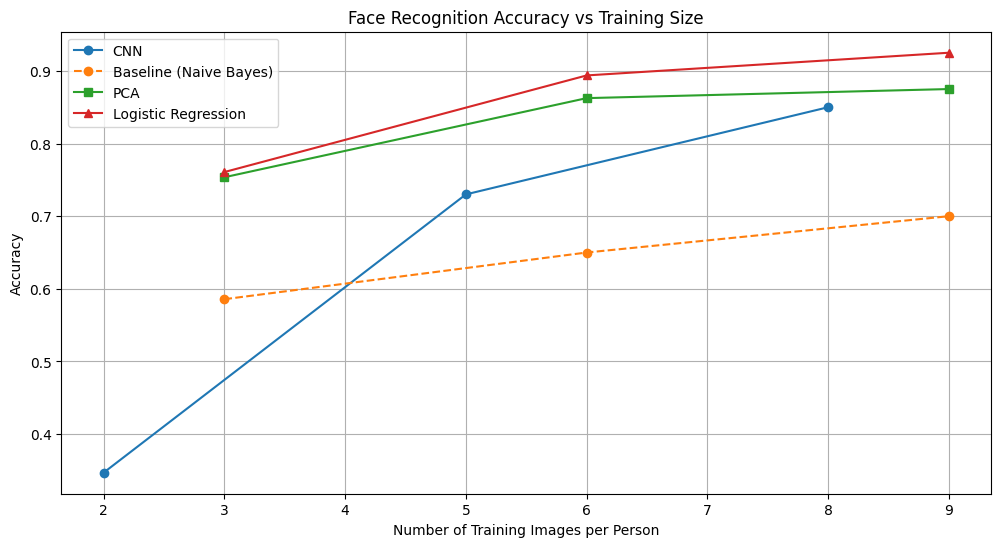

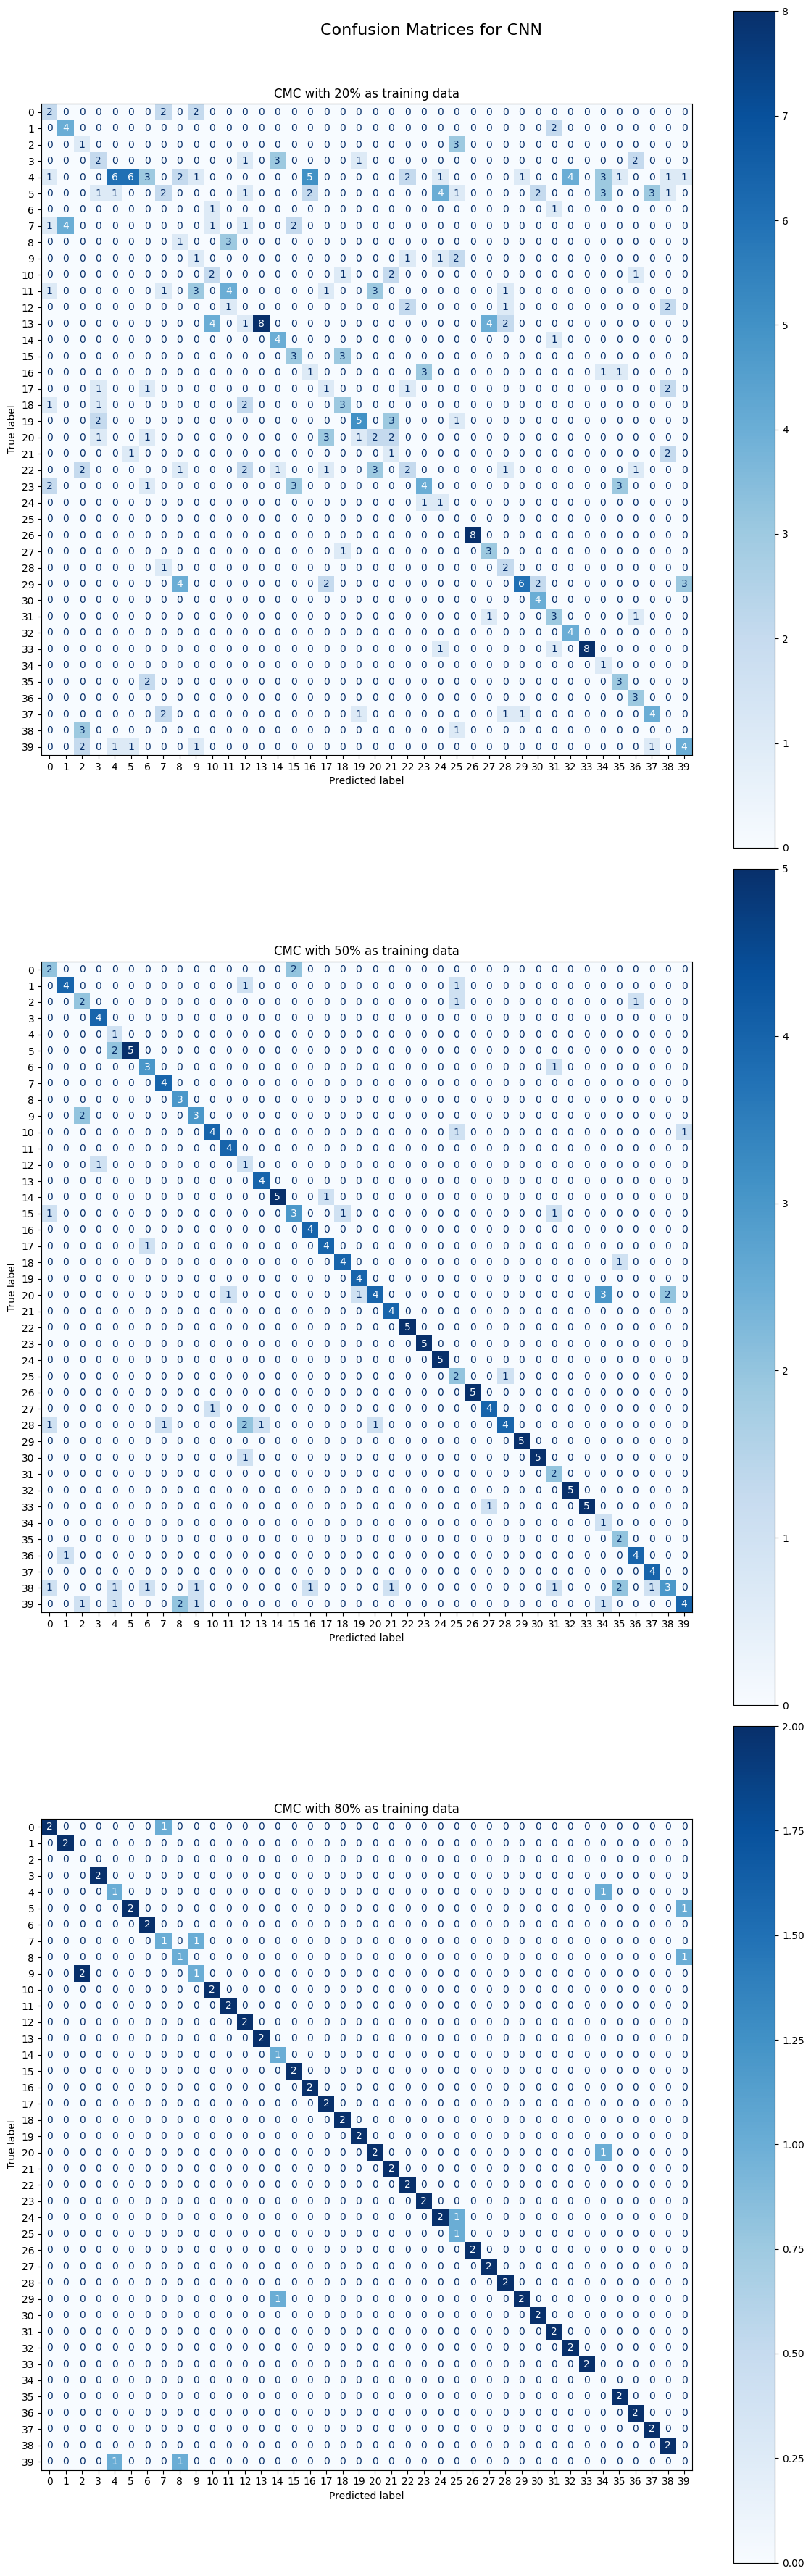

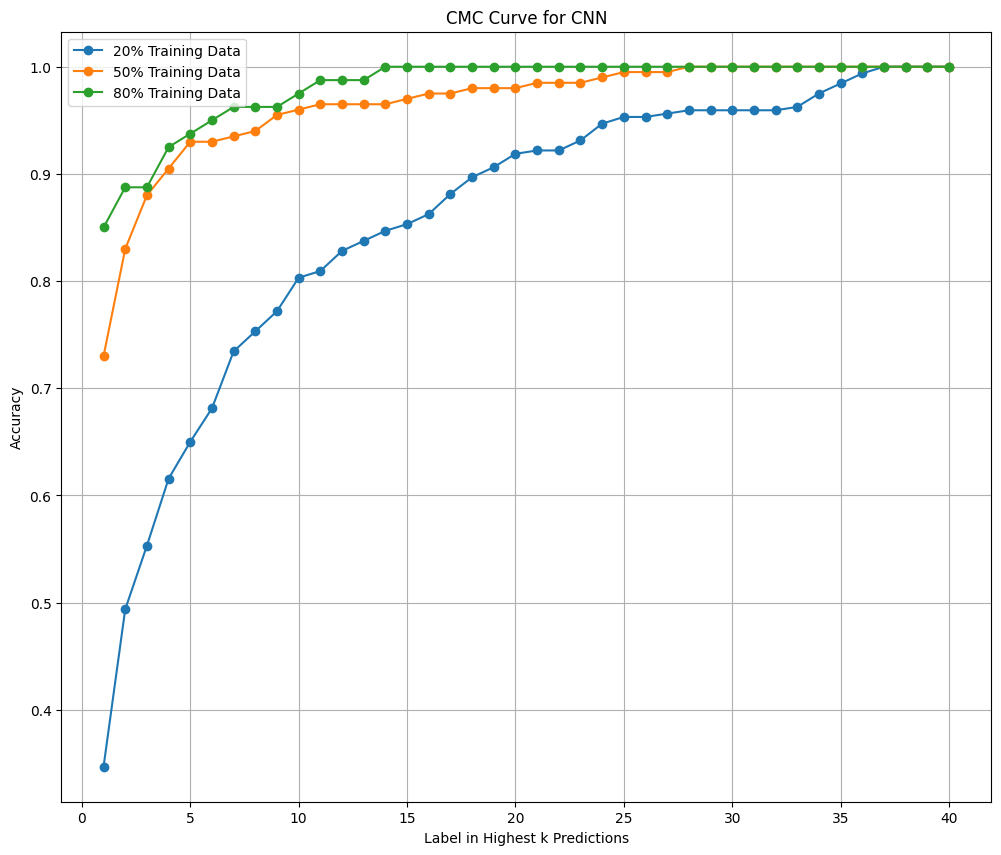

In [ ]:
def calculate_cmc_curve(predictions, true_labels):
  num_test_samples = predictions.shape[0]
  ranks = np.arange(1, 41)
  cmc = np.zeros(len(ranks))

  # Sort predictions in descending order to get ranks
  sorted_indices = np.argsort(predictions, axis=1)[:, ::-1]

  for i in range(num_test_samples):
      true_label = true_labels[i]
      # Find the rank of the true label
      rank_of_true_label = np.where(sorted_indices[i] == true_label)[0][0] + 1

      # Update CMC curve: if rank <= r, then it's a correct match at rank r
      cmc[rank_of_true_label - 1:] += 1

  cmc = cmc / num_test_samples
  return cmc, ranks

# Accuracy vs Training Size
plt.figure(figsize=(12, 6))
plt.plot(cnn_results['train_k'], [accuracy_score(test, pred) for test,pred in cnn_results['CNN']], marker='o', label='CNN')
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['Baseline']], marker='o', linestyle='--', label='Baseline (Naive Bayes)')
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['PCA']], marker='s', label='PCA')
plt.plot(results['train_k'], [accuracy_score(test,pred) for test,pred in results['Logistic Regression']], marker='^', label='Logistic Regression')

plt.title('Face Recognition Accuracy vs Training Size')
plt.xlabel('Number of Training Images per Person')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(3, 1, figsize=(12, 36))
fig.suptitle(f"Confusion Matrices for CNN", fontsize=16)

for ax, (test, pred), size in zip(axes, cnn_results['CNN'], cnn_results['train_k']):
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test, pred))
  disp.plot(cmap='Blues', ax=ax, colorbar=True)
  ax.set_title(f"CMC with {size*10}% as training data")

plt.tight_layout()
plt.show()

# CMC Curve
plt.figure(figsize=(12, 10))
# print(cnn_results['CNN_raw'])
for (pred, test), size in zip(cnn_results['CNN_raw'], cnn_results['train_k']):
  cmc_curve, ranks = calculate_cmc_curve(pred, test)
  plt.plot(ranks, cmc_curve, marker='o', label=f"{size*10}% Training Data")

plt.title('CMC Curve for CNN')
plt.xlabel('Label in Highest k Predictions')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# IMDB Movie Review Dataset
Description from https://www.tensorflow.org/datasets/catalog/imdb_reviews:
> Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

In [ ]:
import tensorflow_datasets
import numpy as np

Load dataset

In [ ]:
dataset, info = tensorflow_datasets.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.K5LW9S_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.K5LW9S_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.K5LW9S_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Get subset of the data for training and testing (2000 samples each). Convert Keras dataset to lists of strings and labels.

In [312]:
x_train = []
y_train = []

for sample, label in train_dataset.take(2000):
  x_train.append(sample)
  y_train.append(label.numpy())

x_train = tf.stack(x_train)
y_train = np.asarray(y_train)

print(x_train[0])
print(y_train[0])

x_test = []
y_test = []

for sample, label in test_dataset.take(2000):
  x_test.append(sample)
  y_test.append(label.numpy())

x_test = tf.stack(x_test)
y_test = np.asarray(y_test)

print(x_test[0])
print(y_test[0])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
0
tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, an

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

max_features = 5000
maxlen = 200

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Add your baseline
The Naive Bayes works by first taking a held-out set, then using it to search for the ideal hyper parameters Once it finds the hyper parameters, it creates a model based on the full training set, using those hyper parameters. The model itself uses a vectorizer to tokenize the words. Then it fits a multinomial Naive Bayes model to the data.

We chose the Naive Bayes model for this problem because it provides us a simple point of comparison for the RNN. It should be the bare minimum that the RNN should be able to outperform.

In [310]:
# Naive Bayes
def run_baseline_model(x_train_idx, y_train, x_test_idx, y_test):
    print("\n--- Running Baseline (Naive Bayes) ---")
    # Convert integer lists back to strings for TF-IDF
    x_train_str = [" ".join(map(str, x)) for x in x_train_idx]
    x_test_str = [" ".join(map(str, x)) for x in x_test_idx]

    X_tr_sub, X_held_out, y_tr_sub, y_held_out = train_test_split(x_train_str, y_train, test_size=0.2, stratify=y_train)


    best_acc = -1
    best_f = None
    features = [2000, 5000, 10000]
    for f in features:
      vectorizer = TfidfVectorizer(max_features=f)
      X_train_tfidf = vectorizer.fit_transform(X_tr_sub)
      X_test_tfidf = vectorizer.transform(X_held_out)

      clf = MultinomialNB()
      clf.fit(X_train_tfidf, y_tr_sub)

      y_pred = clf.predict(X_test_tfidf)
      acc = accuracy_score(y_held_out, y_pred)

      if acc > best_acc:
        best_acc = acc
        best_f = f


    best_acc = -1
    best_a = None

    alphas = [1e-3, 1e-2, 1e-1, 1.0, 10.0]
    for a in alphas:
      vectorizer = TfidfVectorizer(max_features=best_f)
      X_train_tfidf = vectorizer.fit_transform(X_tr_sub)
      X_test_tfidf = vectorizer.transform(X_held_out)

      clf = MultinomialNB(alpha=a)
      clf.fit(X_train_tfidf, y_tr_sub)

      y_pred = clf.predict(X_test_tfidf)
      acc = accuracy_score(y_held_out, y_pred)

      if acc > best_acc:
        best_acc = acc
        best_a = a

    # print(best_a, " ", best_f)

    vectorizer = TfidfVectorizer(max_features=best_f)
    X_train_tfidf = vectorizer.fit_transform(x_train_str)
    X_test_tfidf = vectorizer.transform(x_test_str)

    clf = MultinomialNB(alpha=best_a)
    clf.fit(X_train_tfidf, y_train)

    y_pred = clf.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Baseline Accuracy: {acc:.4f}")
    return acc, cm


bayes_x_train = []
for sample in x_train:
  bayes_x_train.append(sample.numpy())

bayes_x_train = np.asarray(bayes_x_train)

bayes_x_test = []
for sample in x_test:
  bayes_x_test.append(sample.numpy())

bayes_x_test = np.asarray(bayes_x_test)

# Run on TEST set for final comparison
base_acc, base_cm = run_baseline_model(bayes_x_train, y_train, bayes_x_test, y_test)


--- Running Baseline (Naive Bayes) ---
Baseline Accuracy: 0.6035


# Run the experiments



In [ ]:
# RNN
def run_rnn_model(x_train, y_train, x_test, y_test, learning_rate, batch_size):
    print("\n--- RNN ---")

    # Create vocabulary
    vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_features, output_sequence_length=maxlen)# output_mode="int")
    vectorizer.adapt(x_train)

    initializer = tf.keras.initializers.HeNormal()

    model = Sequential([
      vectorizer,
      Embedding(input_dim=max_features, output_dim=64, mask_zero=True),
      SimpleRNN(32, kernel_initializer=initializer, bias_initializer='zeros',),
      Dense(64, activation='relu', kernel_initializer=initializer, bias_initializer='zeros'),
      Dense(1, activation='sigmoid', kernel_initializer=initializer, bias_initializer='zeros')
    ])

    # Create held-out/validation set
    idx = tf.random.shuffle(tf.range(tf.shape(x_train)[0]))
    x_shuffled = tf.gather(x_train, idx)
    y_shuffled = tf.gather(y_train, idx)

    split = round(0.8*len(x_train))
    x_train_subset = x_shuffled[:split]
    y_train_subset = y_shuffled[:split]
    x_val = x_shuffled[split:]
    y_val = y_shuffled[split:]


    # **TODO** Learning rate needs to be searched for
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, verbose=1)
    model_save = tf.keras.callbacks.ModelCheckpoint(filepath="rnn_model.keras", monitor='val_accuracy', save_best_only=True)

    # Train on x_train_subset, validate on x_val
    # **TODO** Batch size needs to be searched for
    history = model.fit(x_train_subset, y_train_subset,
                        epochs=40,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        verbose=1,
                        callbacks=[early_stop, model_save])


    # Final evaluation on TEST set
    model.load_weights('rnn_model.keras')
    if x_test is None:
      x_test = x_val
      y_test = y_val

    print("\nEvaluating on Test Set...")

    # Predictions for CM
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"RNN Test Accuracy: {acc:.4f}")

    return history, acc, cm

learning_rate = [0.001, 0.0001, 0.00001]
batch_sizes = [32, 64, 128]

best_size = None
best_acc = -1
for size in batch_sizes:
  rnn_hist, rnn_acc, rnn_cm = run_rnn_model(x_train, y_train, x_test=None, y_test=None, learning_rate=0.0001, batch_size=size)
  if rnn_acc > best_acc:
    best_acc = rnn_acc
    best_size = size


best_lr = None
best_acc = -1
for lr in learning_rate:
  rnn_hist, rnn_acc, rnn_cm = run_rnn_model(x_train, y_train, x_test=None, y_test=None, learning_rate=lr, batch_size=best_size)
  if rnn_acc > best_acc:
    best_acc = rnn_acc
    best_lr = lr



print(f"Best learning rate: {best_lr} batch size: {best_size}")
rnn_hist, rnn_acc, rnn_cm = run_rnn_model(x_train, y_train, x_test, y_test, learning_rate=best_lr, batch_size=best_size)


--- RNN ---
Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.5027 - loss: 0.7010 - val_accuracy: 0.5025 - val_loss: 0.7028
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.5794 - loss: 0.6668 - val_accuracy: 0.5200 - val_loss: 0.7038
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.6719 - loss: 0.6387 - val_accuracy: 0.5200 - val_loss: 0.7056
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7408 - loss: 0.6008 - val_accuracy: 0.5200 - val_loss: 0.7072
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8148 - loss: 0.5464 - val_accuracy: 0.5225 - val_loss: 0.7112
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8581 - loss: 0.4771 - val_accuracy: 0.5300 - val_loss: 0.7186
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8949 - loss: 0.4017 - val_accuracy: 0.5275 - val_loss: 0.7325
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9249 - loss: 0.3344 - val_accurac

# Report your results

Both the models performed rather poorly on the dataset. The Naive Bayes Model scored only 10% more than we would expect random chance to get. The RNN scored higher most of the time. However, it proved to be very unstable. Between training runs the model would vary by a large amount. One run it would be over 70% accurate, while the next it would be close to 50%. We attempted to alleviate this randomness by setting the seeds of tensorflow, numpy, and random, but this did not remove all of the instability.

The RNN model was also sensitive to the hyperparameters. With non-optimal hyperparameters, the model would just fail to generalize at all outside of the training set. The exact amount the model was sensitive to the choice of hyperparameters is hard to tell because of the randomness in training, but poor choices frequently led to the model performing worse than 50% on the validation set. In other words, it performed worse than randomly flipping a coin to select a label would.

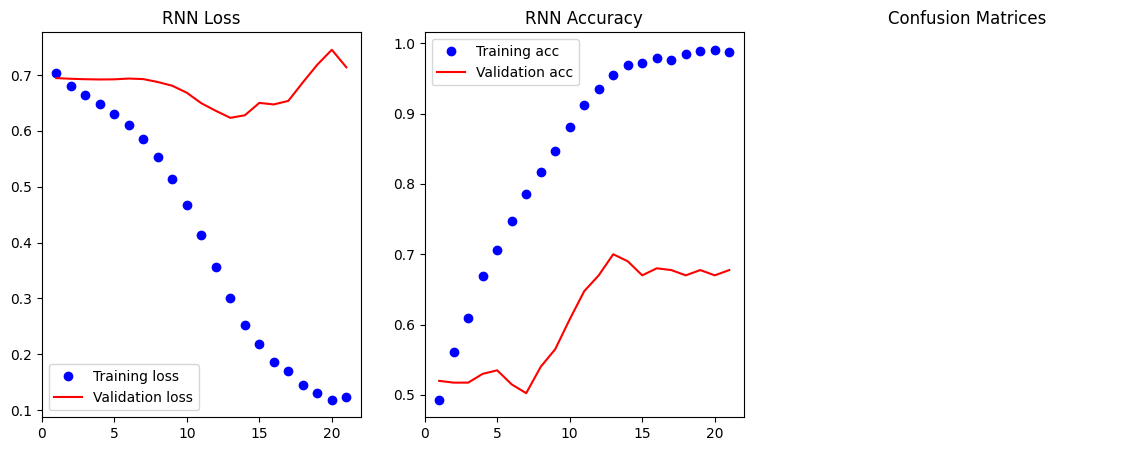

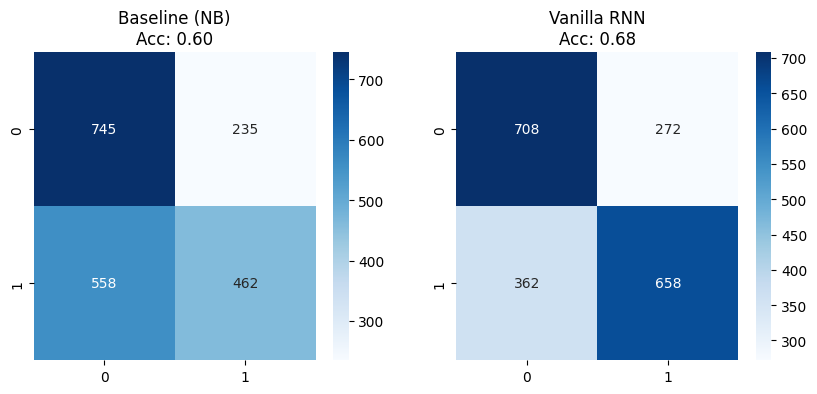

In [311]:
# Visualization
def plot_comparison(base_cm, rnn_cm, rnn_hist):
    # Plot Training History
    history_dict = rnn_hist.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Curve
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('RNN Loss')
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 3, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('RNN Accuracy')
    plt.legend()

    # Confusion Matrices
    plt.subplot(1, 3, 3)
    plt.title("Confusion Matrices")
    plt.axis('off')

    # We will just show them as heatmaps below separately for clarity
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(base_cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title(f"Baseline (NB)\nAcc: {base_acc:.2f}")

    sns.heatmap(rnn_cm, annot=True, fmt='d', cmap='Blues', ax=ax[1])
    ax[1].set_title(f"Vanilla RNN\nAcc: {rnn_acc:.2f}")
    plt.show()

plot_comparison(base_cm, rnn_cm, rnn_hist)

# Extra Credit (10 points)

Explore data augmentation techniques for both tasks.
* (3 points) For the image task, you may use the built-in Keras data augmentation function (tf.keras.preprocessing.image.ImageDataGenerator).
* (5 points) For the text task, you may find an external function that you import or write your own data augmentation.
* (2 points) Describe what data augmentation methods you used and the motivation behind them (why you thought they would help).
